## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('datasets/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
round(df['converted'].mean(),4)

0.1197

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
not_treat_new_page = df.query('group !="treatment" & landing_page == "new_page"').group.count() 
treat_old_page = df.query('group == "treatment" & landing_page == "old_page"').group.count() 

not_treat_new_page + treat_old_page

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'control') & (df['landing_page']=='old_page'))]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2**

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates('user_id')

`4.` Use **df2** 

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
round(df2['converted'].mean(),4)

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
round(df2.query('group == "control"')['converted'].mean(),4)

0.1204

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
round(df2.query('group == "treatment"')['converted'].mean(),4)

0.1188

d. What is the probability that an individual received the new page?

In [17]:
round(len(df2[df2['landing_page'] == 'new_page'])/ len(df2),4)

0.5001

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Answer: According to the results above, it can be seen that the probability that an individual received the new page is 0.5001 meaning there is a half chance that an individual would also receive the old page as well.

The control group has a higher conversion rate (0.1204) than the treatment group (0.1188) which is only by a small difference. Still, there is no sufficient evidence that the treatment page leads to more conversions. This is because we need to run experiments to prove that is the case so it is important to define what is our null and alternative hypothesis and p-value in order to make an executive decision whether to launch the new page or run the old page as normal.    

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


**$H_{0:} $** $p_{new} $** - $p_{old}$**≤0

**$H_{1:} $** $p_{new} $** - $p_{old}$**>0

**Null Hypothesis:** The old page remains to be better than the new page.
<br><br>
**Alternative Hypothesis:** The new page performs better than the old page.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].mean()
round(p_new,4)

0.1196

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].mean()
round(p_old,4)

0.1196

c. What is $n_{new}$?

In [20]:
n_new = len(df2.query('landing_page == "new_page"')['converted'])
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = len(df2.query('landing_page == "old_page"')['converted'])
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_pg_converted_simulation = np.random.binomial(1, p_new, n_new)
new_pg_converted_simulation = round(new_pg_converted_simulation.mean(),4)
new_pg_converted_simulation

0.1188

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_pg_converted_simulation = np.random.binomial(1, p_old, n_old)
old_pg_converted_simulation = round(old_pg_converted_simulation.mean(),4)
old_pg_converted_simulation

0.1187

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
obs_diff = new_pg_converted_simulation - old_pg_converted_simulation
obs_diff

0.00010000000000000286

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []

for _ in range(10000):
    new_pg_converted_simulation = np.random.binomial(1, p_new, n_new)
    old_pg_converted_simulation = np.random.binomial(1, p_old, n_old)
    p_diffs.append(new_pg_converted_simulation.mean() - old_pg_converted_simulation.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

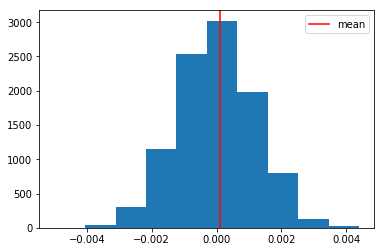

In [26]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='red', label='mean')
plt.legend()
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
(p_diffs > obs_diff).mean()

0.4653

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

According to what was computed above in part j, this is known as the P-value. This value is the probability of observing the statistic (or one more extreme in favour of the alternative) given that the Null hypothesis is true. As you can see the P-value is higher than the Type I error rate which is 0.05. This means that the new page does not perform better than the old page in terms of conversion rates. Therefore, we fail to reject the Null hypothesis and continue to run the old page as normal.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = sum(df2.query('landing_page == "old_page"')['converted'])
convert_new = sum(df2.query('landing_page == "new_page"')['converted'])
n_old = len(df2.query('landing_page == "old_page"')['converted'])
n_new = len(df2.query('landing_page == "new_page"')['converted'])


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

As the z-score is the number of standard deviation a data point is from the population mean. A negative z-score means that the data point is located on the left side of the distribution. There, we fail to reject the Null hypothesis meaning the conversion rates for the old page is greater than or equal to the new page. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression for this particular problem we want to determine and predict whether the page will have conversion or not. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1

df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

df2.drop('control', axis=1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        18:37:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [33]:
# Interpret the coefficients

round(1/np.exp(results.params[1]),4)

1.0151

For each 1 unit decrease in ab_page, conversion is 1.0151 times as likely holding all else constant. 

In [34]:
# How to get a one-tailed test p-value?
1-0.19/2

0.905

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

According to the results the p-value for the new page (0.19) is greater than 0.05 so therefore it is not statistically significant. For this problem, we are performing a logistic regression to experiment a two-tailed test in other words we want to find out the two possble outcomes. 

The Null and Alternative hypothesis for this Logistic Regression model

**$H_{0:} $** $p_{old} $** - $p_{new}$**=0

**$H_{1:} $** $p_{old} $** - $p_{new}$**≠0

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Considering other factors or explanatory variables will help to make the test results of our regression model more reliable and accurate when it comes to making decisions whether to launch the new page or not. Although adding additional terms into the regression model will affect the results such as outliers and mutlicolinearity which might afftect the p-value.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
countries_df = pd.read_csv('datasets/countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [36]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [37]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [38]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
### Fit Your Linear Model And Obtain the Results

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','CA','US']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        18:37:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

In [40]:
round(1/np.exp(results.params[1:3]),4)

CA    1.052
US    1.010
dtype: float64

According to the results it can be seen that users from the United States are 1.010 times as more likely to convert comparing to United Kingdom users. However, Users from Canada are 1.052 as more likely to decrease in terms of conversions comparing to users in United Kingdom.  

From the results above, the country variables are not statistically significant with regards to conversion rates. Therefore, the company should not launch the new page as the results did not prove that the new page is better than the old page.

<a id='conclusions'></a>
## Conclusions

Throughout this project, we used 3 different approaches to determine whether the company should implement and launch the new page or run the old page as normal for the e-commerce website. 

According to the first approach based on Probability - the probability of an individual receiving the new page is 0.5001 which means that there is 50/50 chance of receiving the old page. Moreover, the control group has a higher con version rate (0.1204) than the treatment group (0.1188). 

For the second approach based on A/B test, after running simulations we got a p-value that is higher than the Type I error (0.05) meaning that the new page does not perform better than the old page in relation to conversion rates. We therefore fail to reject the Null hypothesis.  

For the final approach which is the Logistic Regression Model - the p-value for the new page is 0.19 which is greater than 0.05 so it is not statistically significant.  Looking at the results for the interaction between page and country. We can see that there is no significant effects on conversion rates.   
